# Choosing new values for krmax and kmax

## Goals:
 - only small changes to mean climate relative to default
 - improve p50 parameter sensitivity
 - improve 2-variable relationships, e.g. to drydown
 
## Specifics:
 - kmax is too high for shrubs and grasses
     - leading to very small p50 sensitivity
 - krmax varies by PFT, without strong justification

In [90]:
import xarray as xr
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import netCDF4
import os
import cftime
import pandas as pd
%matplotlib inline

## What are the default values for kmax and krmax??

In [2]:
basepftfile = '/glade/p/cgd/tss/people/oleson/modify_param/clm5_params.c200402_kwo.c200422.nc'
defaults    = xr.open_dataset(basepftfile)
pftnames = ['BG','NEMT','NEBT','NDBT','BETT','BEMT','BDTT','BDMT','BDBT','BES','BDMS','BDBS','C3ArG','C3G','C4G','C3C']

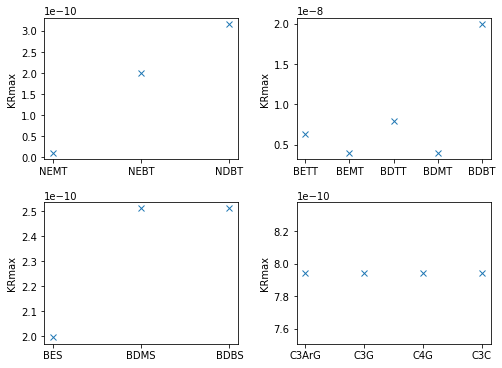

In [42]:
pftkey = [1,4,9,12,16]
plt.figure(figsize=[8,6])
for i in range(4):
    ax = plt.subplot(2,2,i+1)
    krmax = defaults['krmax'][pftkey[i]:pftkey[i+1]].values
    plt.plot(1+np.arange(len(krmax)),krmax,'x')
    plt.xticks(1+np.arange(len(krmax)),pftnames[pftkey[i]:pftkey[i+1]])
    plt.ylabel('KRmax')
plt.subplots_adjust(hspace=0.3)
plt.subplots_adjust(wspace=0.3)

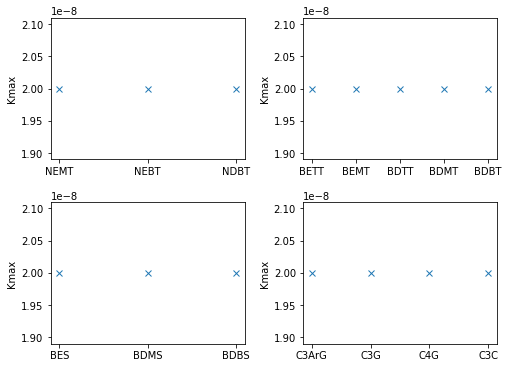

In [51]:
plt.figure(figsize=[8,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    kmax = defaults['kmax'][0,pftkey[i]:pftkey[i+1]].values
    plt.plot(1+np.arange(len(kmax)),kmax,'x')
    plt.xticks(1+np.arange(len(kmax)),pftnames[pftkey[i]:pftkey[i+1]])
    plt.ylabel('Kmax')
plt.subplots_adjust(hspace=0.3)
plt.subplots_adjust(wspace=0.3)

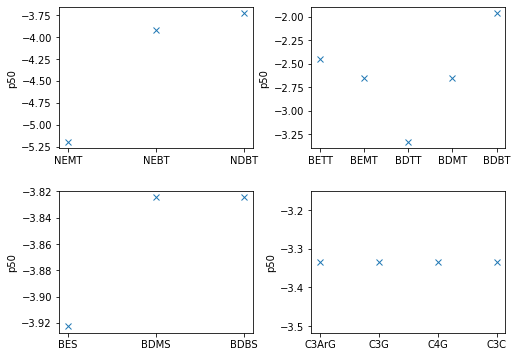

In [53]:
plt.figure(figsize=[8,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    p50 = defaults['psi50'][0,pftkey[i]:pftkey[i+1]].values/101972
    plt.plot(1+np.arange(len(p50)),p50,'x')
    plt.xticks(1+np.arange(len(p50)),pftnames[pftkey[i]:pftkey[i+1]])
    plt.ylabel('p50')
plt.subplots_adjust(hspace=0.3)
plt.subplots_adjust(wspace=0.3)

## Start with KRmax
 - want to remove PFT variation, and choose a reasonable value
 - test for p50 sensitivity with a test of +50000 mm to the default p50
 - need to include this test for the default paramset as well
 - broadleaf evergreen trees likely the first to complain
 - start at 6.3e-9 (BETT default) and work down to 1.8e-9
 - may have to readjust upwards once we decrease kmax
 - likely necessary to iterate back and forth between adjusting krmax and kmax

In [10]:
krmax_vals = np.linspace(1.8e-9,6.3e-9,10)
ct = 1
for i in range(len(krmax_vals)):
    for j in range(2):
        ct +=1
        
        pftfile = 'paramfiles/PHSens'+str(ct).zfill(3)+'.nc'
        nlfile = 'nl_mods/PHSens'+str(ct).zfill(3)+'.txt'
        
        print(pftfile)
        
        cmd = 'cp '+basepftfile+' '+pftfile
        os.system(cmd)
        
        cmd = 'touch '+nlfile
        os.system(cmd)
        
        dset = netCDF4.Dataset(pftfile,'r+')
        dset['krmax'][:]=krmax_vals[i]

        if j==0:
            p50 = defaults['psi50'].copy(deep=True)+50000
            dset['psi50'][:]=p50.values
        dset.close()        


paramfiles/PHSens002.nc
paramfiles/PHSens003.nc
paramfiles/PHSens004.nc
paramfiles/PHSens005.nc
paramfiles/PHSens006.nc
paramfiles/PHSens007.nc
paramfiles/PHSens008.nc
paramfiles/PHSens009.nc
paramfiles/PHSens010.nc
paramfiles/PHSens011.nc
paramfiles/PHSens012.nc
paramfiles/PHSens013.nc
paramfiles/PHSens014.nc
paramfiles/PHSens015.nc
paramfiles/PHSens016.nc
paramfiles/PHSens017.nc
paramfiles/PHSens018.nc
paramfiles/PHSens019.nc
paramfiles/PHSens020.nc
paramfiles/PHSens021.nc


In [14]:
# also create a p50 perturbation for the default case
pftfile = 'paramfiles/PHSens'+str(1).zfill(3)+'.nc'
nlfile = 'nl_mods/PHSens'+str(1).zfill(3)+'.txt'
print(pftfile)
cmd = 'cp '+basepftfile+' '+pftfile
os.system(cmd)
cmd = 'touch '+nlfile
os.system(cmd)
p50 = defaults['psi50'].copy(deep=True)+50000
dset = netCDF4.Dataset(pftfile,'r+')
dset['psi50'][:]=p50.values
dset.close()

paramfiles/PHSens001.nc


## Analysis with first ensemble

In [2]:
#for use on Casper
from dask_jobqueue import SLURMCluster
from dask.distributed import Client
cluster = SLURMCluster(cores=18,
                     processes=18, memory="190GB",
                     project='P93300641',
                     walltime='3:00:00')
cluster.scale(18)
client = Client(cluster)

In [3]:
client

Client Scheduler: tcp://10.12.205.14:37529 Dashboard: http://10.12.205.14:8787/status,Cluster Workers: 18 Cores: 18 Memory: 190.08 GB


In [171]:
# define some info for the ensemble 
ens = 2+np.arange(20)
thedir = '/glade/scratch/djk2120/kmax_ens/output/'
paths = [thedir+'PHSens'+str(ee).zfill(3)+'_h1.nc' for ee in ens]
#grab the default case from another experiment
#otherdir = '/glade/scratch/djk2120/mini_ens/output/'
#paths = [otherdir+'miniens_oaat'+str(0).zfill(4)+'_h1.nc']+paths
pftnames = ['BG','NEMT','NEBT','NDBT','BETT','BEMT','BDTT','BDMT','BDBT','BES',
            'BDMS','BDBS','C3ArG','C3G','C4G','C3C']
pftindex={}
for i,v in zip(range(16),pftnames):
    pftindex[v]=i

In [172]:
ens_vars = ['FPSN','TLAI']
def preprocess(ds):
    return ds[ens_vars]
ds = xr.open_mfdataset(paths,combine='nested',concat_dim='ens',decode_cf=False,
                       preprocess=preprocess,parallel='True')
ds['ens']=ens

In [173]:
# grab just one copy of the various extra variables
extra_vars = xr.open_dataset(paths[0],decode_cf=False)
for v in extra_vars.data_vars:
    if v not in ens_vars:
        ds[v]=extra_vars[v]
ds['pft']=ds['pfts1d_itype_veg'] #reassign pft variable for easier analysis

In [174]:
# redefine the time dimension
#    xarray not very good at interpreting CESM time fields
time_vector = cftime.num2date(ds['time'].values-16,units=ds['time'].attrs['units'],
                calendar=ds['time'].attrs['calendar'])
ds['time']=xr.DataArray(time_vector,dims='time',attrs=ds['time'].attrs)

In [68]:
# add in parameters
pdir = '/glade/scratch/djk2120/kmax_ens/paramfiles/'
parampaths = [pdir+'PHSens'+str(ee).zfill(3)+'.nc' for ee in ens]
params = xr.open_mfdataset(parampaths,combine='nested',concat_dim='ens',parallel='True')
params['krmax']         = params['krmax'].mean(axis=1)
params['psi50']         = params['psi50'].sel(pft=1).mean(axis=1)-params['psi50'][1,0,1]

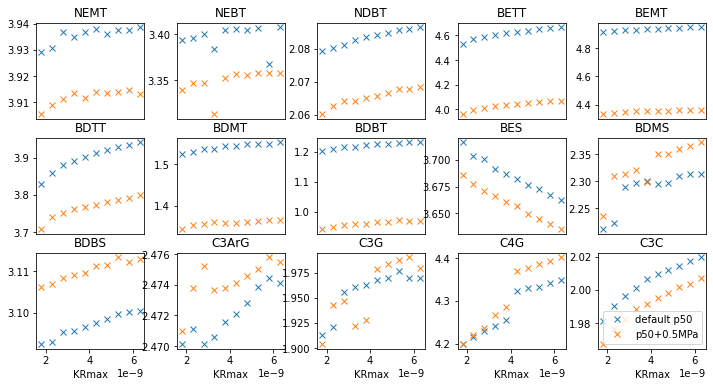

In [175]:
i = 0
plt.figure(figsize=[12,6])
for thispft in pftnames[1:16]:
    i = i+1
    plt.subplot(3,5,i)
    gpp = ds['FPSN'].sel(pft=pftindex[thispft]).mean(axis=[1,2])
    ixd = np.ravel(params['psi50']==0)
    plt.plot(params['krmax'][ixd],gpp[ixd],'x')
    plt.plot(params['krmax'][~ixd],gpp[~ixd],'x')
    if i==15:
        plt.legend(['default p50','p50+0.5MPa'])
    if (i==1|i==6|i==11):
        plt.ylabel('GPP')
    if (i>10):
        plt.xlabel('KRmax')
    else:
        plt.xticks([])
    plt.title(thispft);
plt.subplots_adjust(wspace=0.3)

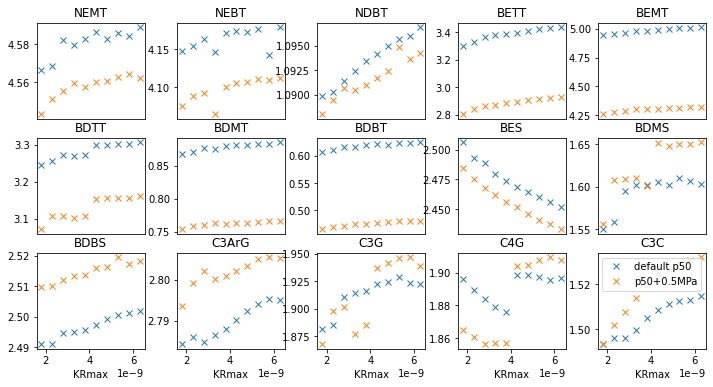

In [177]:
i = 0
plt.figure(figsize=[12,6])
for thispft in pftnames[1:16]:
    i = i+1
    plt.subplot(3,5,i)
    gpp = ds['TLAI'].sel(pft=pftindex[thispft]).mean(axis=[1,2])
    ixd = np.ravel(params['psi50']==0)
    plt.plot(params['krmax'][ixd],gpp[ixd],'x')
    plt.plot(params['krmax'][~ixd],gpp[~ixd],'x')
    if i==15:
        plt.legend(['default p50','p50+0.5MPa'])
    if (i==1|i==6|i==11):
        plt.ylabel('TLAI')
    if (i>10):
        plt.xlabel('KRmax')
    else:
        plt.xticks([])
    plt.title(thispft);
plt.subplots_adjust(wspace=0.3)

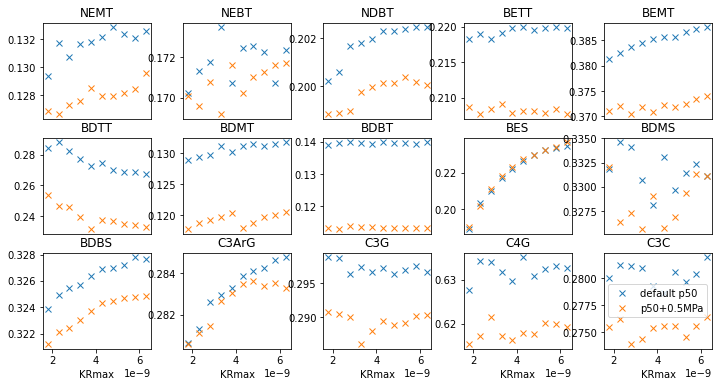

In [144]:
i = 0
plt.figure(figsize=[12,6])
for thispft in pftnames[1:16]:
    i = i+1
    plt.subplot(3,5,i)
    iav = ds['FPSN'].sel(pft=pftindex[thispft]).groupby('time.year').mean(dim='time').std(axis=1).mean(axis=1)
    ixd = np.ravel(params['psi50']==0)
    plt.plot(params['krmax'][ixd],iav[ixd],'x')
    plt.plot(params['krmax'][~ixd],iav[~ixd],'x')
    if i==15:
        plt.legend(['default p50','p50+0.5MPa'])
    if (i==1|i==6|i==11):
        plt.ylabel('GPP')
    if (i>10):
        plt.xlabel('KRmax')
    else:
        plt.xticks([])
    plt.title(thispft);
plt.subplots_adjust(wspace=0.3)

In [147]:
# define some info for the ensemble 
ens = 2+np.arange(20)
thedir = '/glade/scratch/djk2120/kmax_ens/output/'
paths = [thedir+'PHSens'+str(ee).zfill(3)+'_h0.nc' for ee in ens]
#grab the default case from another experiment
#otherdir = '/glade/scratch/djk2120/mini_ens/output/'
#paths = [otherdir+'miniens_oaat'+str(0).zfill(4)+'_h1.nc']+paths
pftnames = ['BG','NEMT','NEBT','NDBT','BETT','BEMT','BDTT','BDMT','BDBT','BES',
            'BDMS','BDBS','C3ArG','C3G','C4G','C3C']
pftindex={}
for i,v in zip(range(16),pftnames):
    pftindex[v]=i

In [149]:
ens_vars = ['FPSN','TWS','SOILWATER_10CM']
def preprocess(ds):
    return ds[ens_vars]
ds = xr.open_mfdataset(paths,combine='nested',concat_dim='ens',decode_cf=False,
                       preprocess=preprocess,parallel='True')
ds['ens']=ens

In [150]:
# redefine the time dimension
#    xarray not very good at interpreting CESM time fields
time_vector = cftime.num2date(ds['time'].values-16,units=ds['time'].attrs['units'],
                calendar=ds['time'].attrs['calendar'])
ds['time']=xr.DataArray(time_vector,dims='time',attrs=ds['time'].attrs)

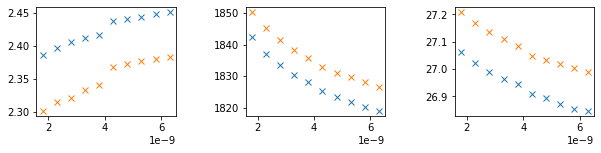

In [162]:
plt.figure(figsize=[10,2])
x = params['krmax']
i = 0
for v in ens_vars:
    i +=1
    y=ds[v].mean(axis=[1,2])
    ixd = np.ravel(params['psi50']==0)
    plt.subplot(1,3,i)
    plt.plot(x[ixd],y[ixd],'x')
    plt.plot(x[~ixd],y[~ixd],'x')    
plt.subplots_adjust(wspace=0.5)

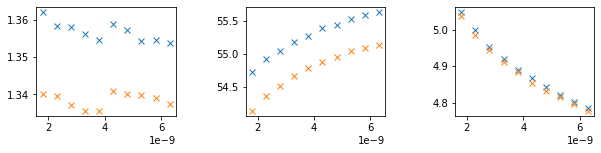

In [166]:
plt.figure(figsize=[10,2])
x = params['krmax']
i = 0
for v in ens_vars:
    i +=1
    y=ds[v].groupby('time.month').mean(dim='time').std(axis=1).mean(axis=1)
    ixd = np.ravel(params['psi50']==0)
    plt.subplot(1,3,i)
    plt.plot(x[ixd],y[ixd],'x')
    plt.plot(x[~ixd],y[~ixd],'x')    
plt.subplots_adjust(wspace=0.5)

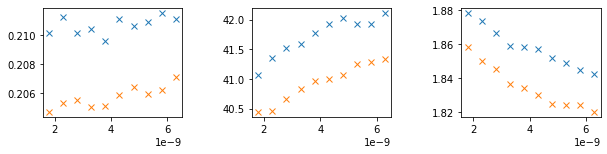

In [167]:
plt.figure(figsize=[10,2])
x = params['krmax']
i = 0
for v in ens_vars:
    i +=1
    y=ds[v].groupby('time.year').mean(dim='time').std(axis=1).mean(axis=1)
    ixd = np.ravel(params['psi50']==0)
    plt.subplot(1,3,i)
    plt.plot(x[ixd],y[ixd],'x')
    plt.plot(x[~ixd],y[~ixd],'x')    
plt.subplots_adjust(wspace=0.5)

In [170]:
d = {'name':pftnames[1:16],'krmax':defaults['krmax'][1:16]}
pd.DataFrame(data=d)

,name,krmax
0,NEMT,1.000000e-11
1,NEBT,1.995262e-10
2,NDBT,3.162278e-10
3,BETT,6.309573e-09
4,BEMT,3.981072e-09
5,BDTT,7.943282e-09
6,BDMT,3.981072e-09
7,BDBT,1.995262e-08
8,BES,1.995262e-10
9,BDMS,2.511886e-10


## Create a kmax ensemble
 - two versions, default krmax and krmax = 5e-9
 - again do a set of default p50 and p50+50000mm
 - sample a broad range of kmax

In [221]:
kmax = np.array([1.6e-8*(3/4)**x for x in np.arange(10)])
kmax = np.round(kmax*1e10)/1e10
efile = '/glade/u/home/djk2120/CLM5PPE/jobscripts/PHSens/PHSens.txt'
ct = 21
for i in range(2):
    for k in range(10):
        for j in range(2):
        
            ct +=1 
            estr = 'PHSens'+str(ct).zfill(3)
            pftfile = 'paramfiles/'+estr+'.nc'
            nlfile  = 'nl_mods/'+estr+'.txt'

            print(pftfile)

            if (1==1):
                cmd = 'cp '+basepftfile+' '+pftfile
                os.system(cmd)
                cmd = 'touch '+nlfile
                os.system(cmd)
                cmd = 'echo '+estr+' >> '+efile
                os.system(cmd)
                
                dset = netCDF4.Dataset(pftfile,'r+')
                dset['kmax'][:]=kmax[k]
                if i==0:
                    dset['krmax'][:]=5e-9

                if j==0:
                    p50 = defaults['psi50'].copy(deep=True)+50000
                    dset['psi50'][:]=p50.values
                dset.close()    

paramfiles/PHSens022.nc
paramfiles/PHSens023.nc
paramfiles/PHSens024.nc
paramfiles/PHSens025.nc
paramfiles/PHSens026.nc
paramfiles/PHSens027.nc
paramfiles/PHSens028.nc
paramfiles/PHSens029.nc
paramfiles/PHSens030.nc
paramfiles/PHSens031.nc
paramfiles/PHSens032.nc
paramfiles/PHSens033.nc
paramfiles/PHSens034.nc
paramfiles/PHSens035.nc
paramfiles/PHSens036.nc
paramfiles/PHSens037.nc
paramfiles/PHSens038.nc
paramfiles/PHSens039.nc
paramfiles/PHSens040.nc
paramfiles/PHSens041.nc
paramfiles/PHSens042.nc
paramfiles/PHSens043.nc
paramfiles/PHSens044.nc
paramfiles/PHSens045.nc
paramfiles/PHSens046.nc
paramfiles/PHSens047.nc
paramfiles/PHSens048.nc
paramfiles/PHSens049.nc
paramfiles/PHSens050.nc
paramfiles/PHSens051.nc
paramfiles/PHSens052.nc
paramfiles/PHSens053.nc
paramfiles/PHSens054.nc
paramfiles/PHSens055.nc
paramfiles/PHSens056.nc
paramfiles/PHSens057.nc
paramfiles/PHSens058.nc
paramfiles/PHSens059.nc
paramfiles/PHSens060.nc
paramfiles/PHSens061.nc
